# Symmetry Constraints

## Geometry of Classical Mechanics

It turns out that we can use the geometric structure of classic mechanics to make a better differential equation solver.  Note, it will only work for mechanics problems, since we are using that structure.  These are referred to as *Symplectic Methods*.

To understand that phrase, we need to dive into some advanced classical mechanics -- sometimes referred to as *Analytical Mechanics*.  A good reference is Goldstein's [Classical Mechanics](https://catalog.library.cornell.edu/catalog/5339062).

You are probably aware that Newton's equations can be expressed as a variational method.  We define the action

$$
S=\int \mathcal{L}(x,\dot{x},t)\,dt
$$

where the Lagrangian is the difference between the kinetic and potential energy,

$$
\mathcal{L} = T-V.
$$

Newton's equations correspond to finding the paths $(x(t),v(t))$ which make the action stationary.

We will not work directly with $\mathcal{L}$.  Rather we work with the Hamiltonian.  The Hamiltonian is defined in terms of the coordinates and the Cannonical Momenta.  The latter are defined by

$$
p=\frac{\delta S}{\delta \dot{x}}
$$

The Hamiltonian is then constructed as

$$
H=p\dot{x}-\mathcal{L},
$$

written in terms of $x$ and $p$.

For example, consider a pendulum.  In phase space coordinates the kinetic energy is
\begin{align}
T &= \frac{1}{2}m v^2\\
  &= \frac{1}{2}m L^2 \dot{\theta}^2
\end{align}
The potential energy is
\begin{align}
V &= m g h\\
  &= -m g L \cos(\theta).
\end{align}
The coordinate is $\theta$, so the canonical momentum is
\begin{align}
p_\theta &= \frac{\partial \mathcal{L}}{\partial \dot{\theta}}\\
&=m L^2 \dot{\theta}
\end{align}
The Hamilonian is then
\begin{align}
H=\frac{1}{2 m L^2} p_\theta^2 -m g L \cos(\theta),
\end{align}
which is simply the energy, written in the cannonical variables.

The utility of the Hamiltonian is that Newton's laws take on a highly structured form
\begin{align}
\partial_t x &= \partial_p H\\
\partial_t p &= -\partial_x H
\end{align}
The equations of motion in this form are often referred to as *Hamilton's Equations*.  They imply a number of important properties -- most notably, energy conservation and the conservation of canonical phase space volume (Liouville's theorem).  One can think of this as a symmetry, and try to produce a numerical integrator which respects the symmetry.

Note -- I wrote this as if $x$ was a scalar -- but in general it is a vector containing all of the dynamical variables.

### Energy Conservation and phase space volume

Within the Hamiltonian framework, energy conservation is trivial
\begin{align}
\partial_t H = \partial_x H \partial_t x + \partial_p H \partial_t p
\end{align}
which vanishes by Hamilton's equations. 

To understand the conservation of phase space volume, lets begin with a 1-dimensional case, where $x$ and $p$ are scalars.  In that case imagine the small triangle in phase space, with corners $(x_1,p_1)=(x,p)$, $(x_2,p_2)=(x+dx,p)$, $(x_3,p_3)=(x,p+dp)$.  

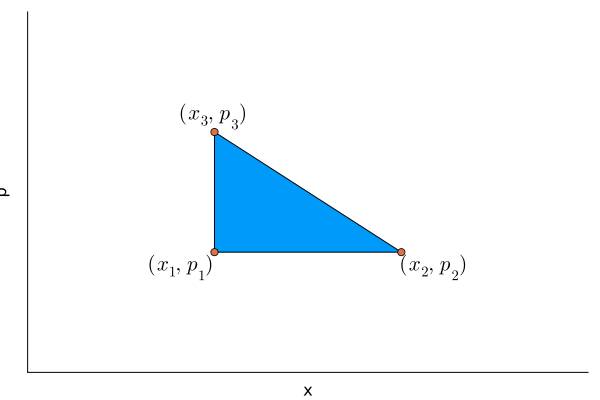

In [10]:
using Plots,LaTeXStrings
x=1;p=1;dx=1;dp=1;
r1=(x,p)
r2=(x+dx,p)
r3=(x,p+dp)
plot(Shape([r1,r2,r3]),label="",xticks=[],yticks=[],xlabel="x",ylabel="p")
scatter!([r1,r2,r3],label="")
annotate!(x,p,(L"(x_1,p_1)",:right,:top))
annotate!(x+dx,p,(L"(x_2,p_2)",:left,:top))
annotate!(x,p+dp,(L"(x_3,p_3)",:bottom))
xlims!(0,3)
ylims!(0,3)

That patch of phase space has area $A=dx\times dp/2$.  If we define $\vec{R}=(x,p)$, then that area can also be written as a cross product, ie $A=|(\vec{R_3}-\vec{R_1})\times(\vec{R_2}-\vec{R_1})|/2$.  Liouville's theorem states that the area of that triangle is preserved under time evolution.  Any geometric shape can be made by piecing together triangles -- so any phase space volume is preserved.  Moreover, when generalized to higher dimensions the same feature persists.  The hypervolume of any geometric shape is preserved.

In the 1D case we can prove this by imagining that we numerically evolve our differential equation via the Euler method.
After evolving for some small time $\delta t$, the first corner will have moved as
\begin{align}
x&\to x+\frac{\partial H}{\partial p} \delta t\\
p&\to p-\frac{\partial H}{\partial x} \delta t.
\end{align}
Here we have evaluated $H$ at the point $(x,p)$.
The second corner moves as
\begin{align}
x+dx&\to x+ dx+\frac{\partial H}{\partial p} \delta t+\frac{\partial^2 H}{\partial x\partial p} dx \delta t\\
p &\to p-\frac{\partial H}{\partial x} \delta t-\frac{\partial^2 H}{\partial x^2} dx \delta t.
\end{align}
Again, we are evaluating $H$ at the first point -- and hence the extra terms.
The third corner moves as
\begin{align}
x&\to x+\frac{\partial H}{\partial p} \delta t+\frac{\partial^2 H}{\partial p^2} dp \delta t\\
p+dp &\to p+dp-\frac{\partial H}{\partial x}  \delta t-\frac{\partial^2 H}{\partial x\partial p}  dp \delta t
\end{align}

The differences between the points are then
\begin{align}
x_2-x_1&= dx\left(1+ \frac{\partial^2 H}{\partial x\partial p} \delta t\right)\\
p_2-p_1&= -dx \frac{\partial^2 H}{\partial x^2} \delta t\\
x_3-x_1&= dp \frac{\partial^2 H}{\partial x\partial p} \delta t\\
p_2-p_1&= -dp \left(1+\frac{\partial^2 H}{\partial x\partial p} \delta t\right)
\end{align}

You can then take the cross-product, and you will see that to order $\delta t$, the phase space volume is preserved.

Note that  this area preservation is only true to leading order in $\delta t$.  For analytic work, you then imagine taking the limit $\delta t \to 0$. 

## Symplectic Structure

I probably will not go over this in class -- but you might be curious about why we refer to the structure of Hamilton's equations as Symplectic.

To get at this structure we make a vector $\vec{R}=(x,p)$.  Hamilton's equations are then 

$$
\partial_t R= J \frac{\partial H}{\partial R}
$$

where $J$ is a block matrix
\begin{equation}
J=\left(
\begin{array}{cc}
0&1\\
-1&0\end{array}
\right)
\end{equation}

If I apply a linear transformation, defining $\bar R_i=\sum_j K_{ij} R_j$, then
\begin{align}
\partial_t \bar R_i &=\sum_{jk} K_{ij} J_{jk} \frac{\partial H}{\partial R_k}\\
&= \sum_{jkl} K_{ij} J_{jk} \frac{\partial{\bar R}_l}{\partial R_k} \frac{\partial H}{\partial {\bar R}_l}\\
&= \sum_{jkl} K_{ij} J_{jk} K^{t}_{kl} \frac{\partial H}{\partial {\bar R}_l}
\end{align}
This will have the same form as the original equation if 

$$
J=KJK^t
$$

which defines $K$ to be a Symplectic matrix.  This is a generalization of an Orthogonal matrix (which has this same form, but with $J=I$).

Thus the form of Hamilton's equations is invarient under a symplectic transformation.  A special case of this is time-evolution, which is a map $(x(t),p(t))\to (x(t'),p(t'))$.  This map must be symplectic.

## Symplectic Integrators

The simplest symplectic integrator is the leapfrog method.  It is based upon using a different grid for the x-points and the p-points.  We use central differences for the derivatives, so
\begin{align}
\partial_t x&= \partial_p H\\
\partial_t p_x&= -\partial_x H
\end{align}
becomes
\begin{align}
x_{i+1}-x_i&= \left(\partial_p H\right)_{i+1/2} \delta t\\
p_{i+1/2}-p_{i-1/2}&= -\left(\partial_x H\right)_{i} \delta t
\end{align}
I'll leave it as an exercise to prove that it is symplectic. Here is a simple implementation, where we assume $\partial_p H$ is only a function of $x$ and $\partial_x H$ is only a function of $p$.

In [12]:
# Stepping Rules
xstep(x,p,dHdp,t,deltat)=x + dHdp(p,t)*deltat
pstep(x,p,dHdx,t,deltat)= p - dHdx(x,t)*deltat

# Allow calling by keywords
xstep(;x,p,dHdp,t,deltat)=xstep(x,p,dHdp,t,deltat)
pstep(;x,p,dHdx,t,deltat)=pstep(x,p,dHdx,t,deltat)

function leapfrogevolve(x0,p1,dHdx,dHdp,timerange)
    ti,tf,dt=timerange
    numsteps=floor(Int,(tf-ti)/dt)
    x=x0
    p=p1
    xresult=Array{typeof(x)}(undef,numsteps+1)
    presult=Array{typeof(p)}(undef,numsteps+1)
    xtimes=Array{typeof(dt)}(undef,numsteps+1)
    ptimes=Array{typeof(dt/2)}(undef,numsteps+1)
    t=ti
    xresult[1]=x
    xtimes[1]=t
    t+=dt/2
    presult[1]=p
    ptimes[1]=t
    t+=dt/2
    for j in 1:numsteps
        # x step
        x=xstep(x,p,dHdp,t,dt)
        xresult[j+1]=x
        xtimes[j+1]=t
        t+=dt/2
        #p step
        p=pstep(x,p,dHdx,t+dt/2,dt)
        presult[j+1]=p
        ptimes[j+1]=t
        t+=dt/2
    end
    return (x=xresult,p=presult,xt=xtimes,pt=ptimes)
end

leapfrogevolve(;x0,p1,dHdx,dHdp,timerange)=leapfrogevolve(x0,p1,dHdx,dHdp,timerange)

leapfrogevolve (generic function with 2 methods)

Note, the output of our function is a `NamedTuple`.  This is a data structure which is convenient for shuffling information around.  Here is an example of how it works.

In [13]:
data=(a=10,b=5,x=7) # create the NamedTuple

(a = 10, b = 5, x = 7)

In [14]:
data[1] # Access entries like you would a normal Tuple

10

In [15]:
data[:a] # Access entries as a look-up table

10

In [16]:
data.a # Access entries as a `struct`

10

In [17]:
keys(data) # Get the names of the elements

(:a, :b, :x)

In [18]:
data.a

10

We can demonstrate this with our pendulum Hamiltonian.  Here the canonical position is θ, the conjugate momentum is $p_\theta=m L^2 \dot{\theta}$, and the Hamiltonian is
\begin{align}
H=\frac{1}{2 m L^2} p_\theta^2 -m g L \cos(\theta).
\end{align}
Hamilton's equations then read
\begin{align}
\partial_t \theta&= \frac{p_\theta}{m L^2}\\
\partial_t p_\theta&=-mgL\sin(\theta)
\end{align}

We adimensionalize, measuring time in units of $\tau=\sqrt{L/g}$, and $p_\theta$ in units of $m L^{3/2}/\sqrt{g}$.  The dimensionless equations are
\begin{align}
\partial_t \theta &= p_\theta\\
\partial_t p_\theta &= -\sin \theta
\end{align}
We can code this up as

In [19]:
pendulum_dHdx(p,t) = p
pendulum_dHdp(θ,t) = sin(θ)

pendulum_dHdp (generic function with 1 method)

Then run the code with

In [20]:
traj1=leapfrogevolve(x0=pi/2. #=initial angle =#,
                     p1=0. #=initial velocity =#,
                     dHdx=pendulum_dHdx,dHdp=pendulum_dHdp,
                     timerange=(0,500,0.1));

In [21]:
using Plots

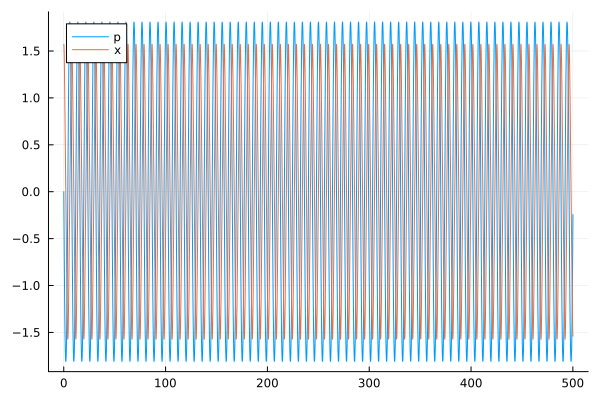

In [22]:
plot(traj1.pt,traj1.p,label="p")
plot!(traj1.xt,traj1.x,label="x")

Despite the relatively large step size, the trajectory remains bounded -- unlike the Euler method where the energy continuously increases

## Higher order Symplectic Methods

There are higher order symplectic methods -- you can look them up or [use a package](https://docs.sciml.ai/DiffEqDocs/stable/solvers/dynamical_solve/#Symplectic-Integrators)

In [25]:
using OrdinaryDiffEq

In [26]:
pendulum_dxdt(x,p,params,t)=p
pendulum_dpdt(x,p,params,t)=-sin(x) 
prob1=DynamicalODEProblem(pendulum_dxdt, pendulum_dpdt, pi/2, 0., (0,50))

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Float64, Float64}} and tType Int64. In-place: false
Non-trivial mass matrix: false
timespan: (0, 50)
u0: (1.5707963267948966, 0.0)

Here is solving it with the Verlet Leapfrog method (the one we implemented)

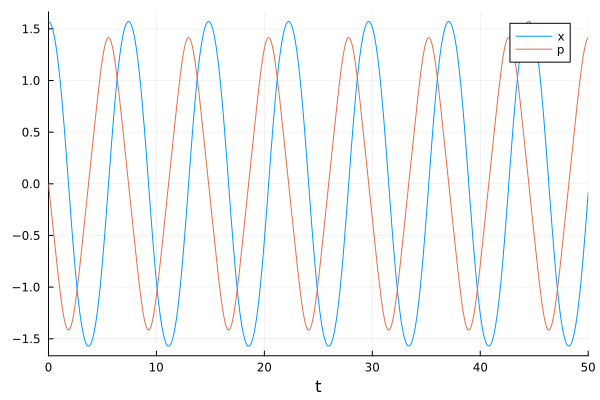

In [27]:
sol1=solve(prob1,VerletLeapfrog(),dt=0.1)
plot(sol1;labels=["x" "p"])

Here is a higher order method

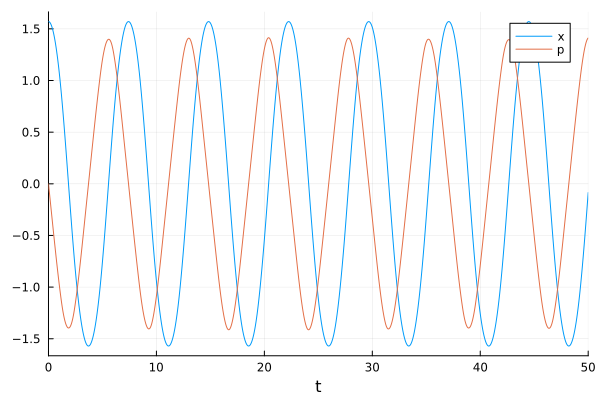

In [28]:
sol2=solve(prob1,SofSpa10(),dt=1.2)
plot(sol2;labels=["x" "p"])